In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from funcs.analysis import *
%matplotlib inline

In [6]:
band = 'r'

In [7]:
def reader(n_subarray):
    return pd.read_csv('../data/merged/{}/{}_band/unclean/lc_{}.csv'.format(obj, band, n_subarray), nrows=None, index_col = ID, dtype = {'catalogue': np.uint8, 'mag_ps': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

In [8]:
obj = 'qsos'
ID  = 'uid'
dr = analysis(ID)
dr.read_in(reader, redshift=False)

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Clean lightcurves using MAD. Need to do this per filter

### Using rolling window to find outliers

In [ ]:
def check_outliers(df, uids):
    # for single band
    MAD_max = pd.DataFrame(columns=['uid','MAD_max', 'MAD_argmax','mag','mjd'])
    # make sure we have multiindexing
    for uid in uids:
        group = df.loc[uid].sort_values('mjd')
        MAD_maxes = {'uid':uid}
        append = False
#         try:
#         n = len(group)
        MAD = abs(group['mag'] - group['mag'].rolling(4, center=True).median().fillna(method='bfill').fillna(method='ffill'))
        if MAD.max() > 0:
            MAD_maxes['MAD_max'] = MAD.max()
            MAD_maxes['MAD_argmax'] = MAD.argmax()
            MAD_maxes['mjd'] = group['mjd'].values[MAD.argmax()]
            MAD_maxes['mag'] = group['mag'].values[MAD.argmax()]
            append = True
        outlier = group[MAD>1]
#         except:
#             pass
        if append:
            MAD_max = MAD_max.append(MAD_maxes, ignore_index=True)

    return MAD_max.astype({'uid':np.uint32}).set_index('uid')

In [ ]:
fig, ax = dr.plot_series(uids, filtercodes='r')
MAD_max = check_outliers(dr.df, df_copy.index.unique())
for axis, uid in zip(ax,uids)[:10]:
    MAD_max_, mag, mjd = MAD_max.loc[uid, ['MAD_max', 'mag', 'mjd']].values.T
    axis.text(0.02, 0.8, 'MAD max: {:.2f}'.format(MAD_max_), transform=axis.transAxes, fontsize=10)
    axis.scatter(mjd, mag, s=100)
    mu, std = grouped.loc[uid,['mag_mean','mag_std']].values.T
    axis.axhline((mu-5*std),lw=0.5)
    axis.axhline((mu+5*std),lw=0.5)

In [34]:
dr.summary()

Number of qsos with lightcurve: 522,006
Number of datapoints in:
SDSS: 1,145,054
PS: 6,215,518
ZTF: 28,571,853


In [29]:
# %%timeit -n 1 -r 1
MAD_max = check_outliers(dr.df, uids[:50])

In [48]:
test = check_outliers(dr.df, dr.idx_uid[:100])['MAD_max'].sort_values(ascending=False)

In [49]:
test

84    1.579565
19    1.527987
58    1.109221
10    1.106580
18    1.058250
        ...   
23    0.156799
96    0.115229
13    0.110136
95    0.102715
80    0.087620
Name: MAD_max, Length: 99, dtype: float64

(<Figure size 1440x2160 with 10 Axes>,
 <AxesSubplot:xlabel='mjd', ylabel='mag'>)

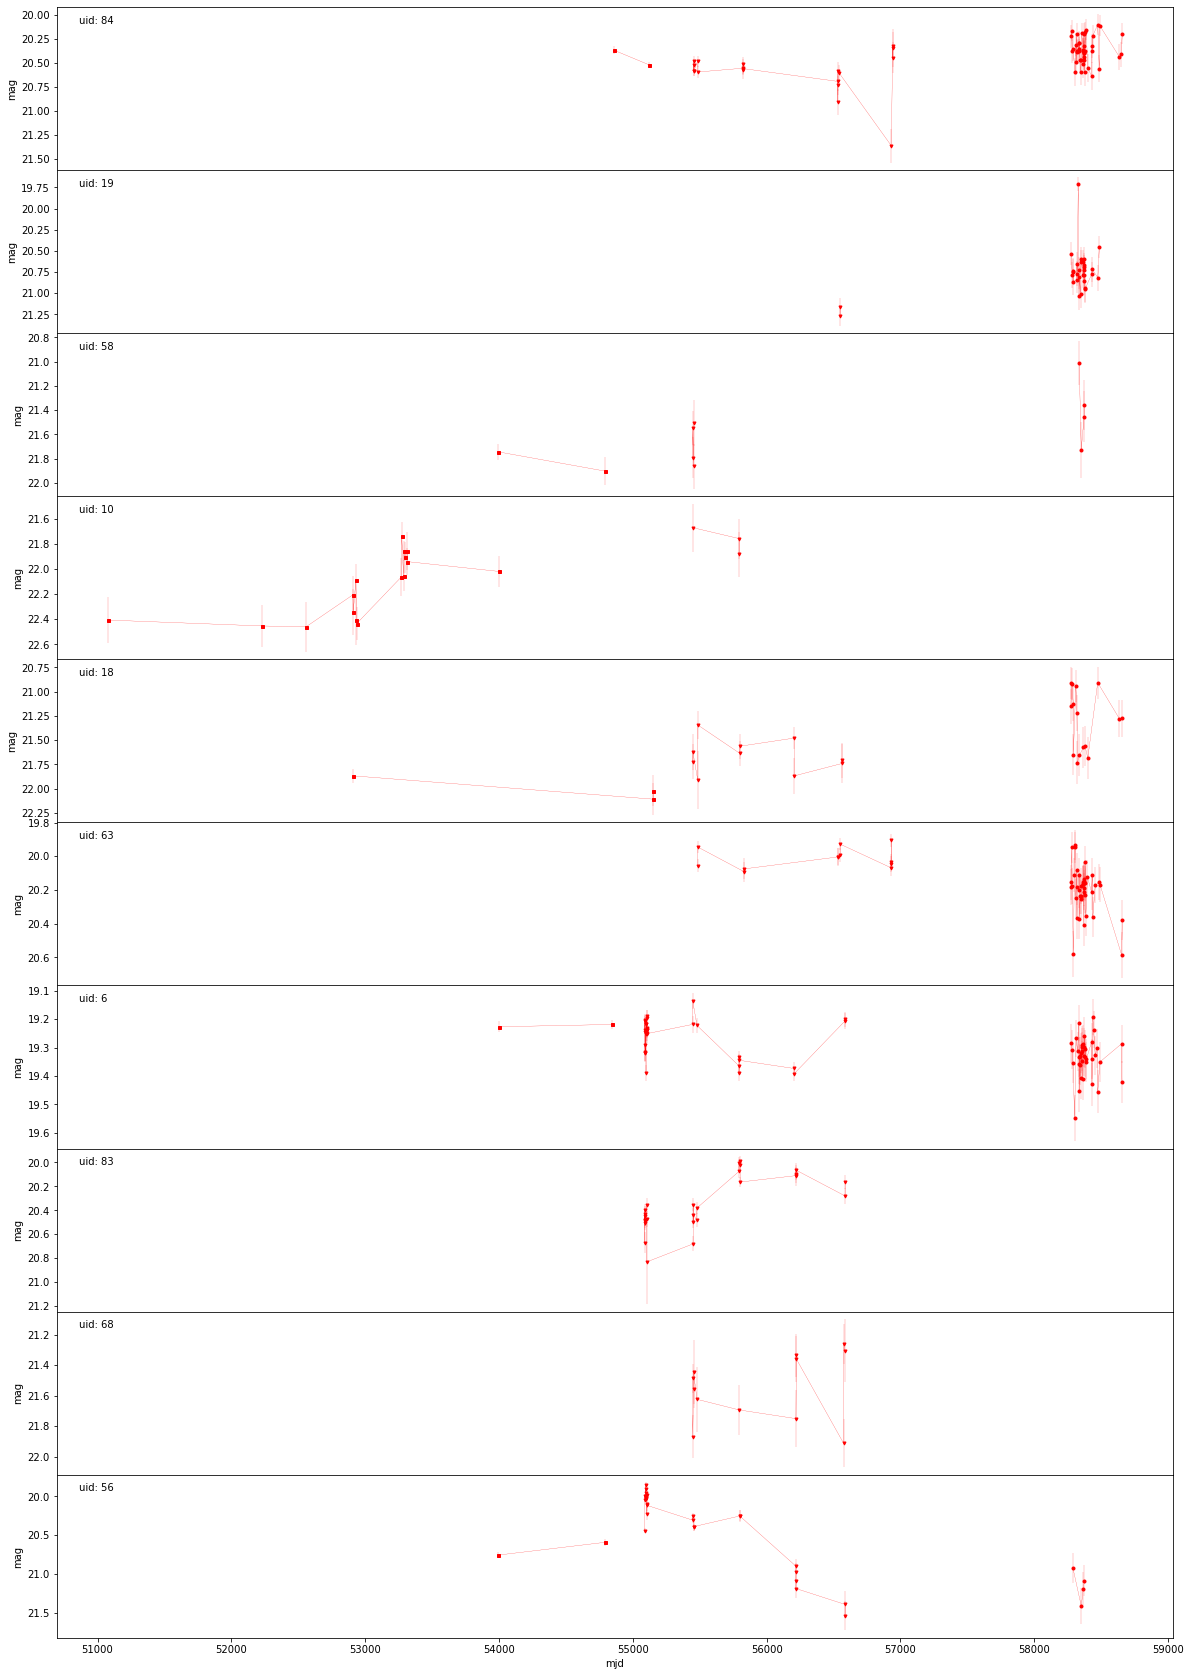

In [51]:
dr.plot_series(test.index[:10], filtercodes='r')

<AxesSubplot:>

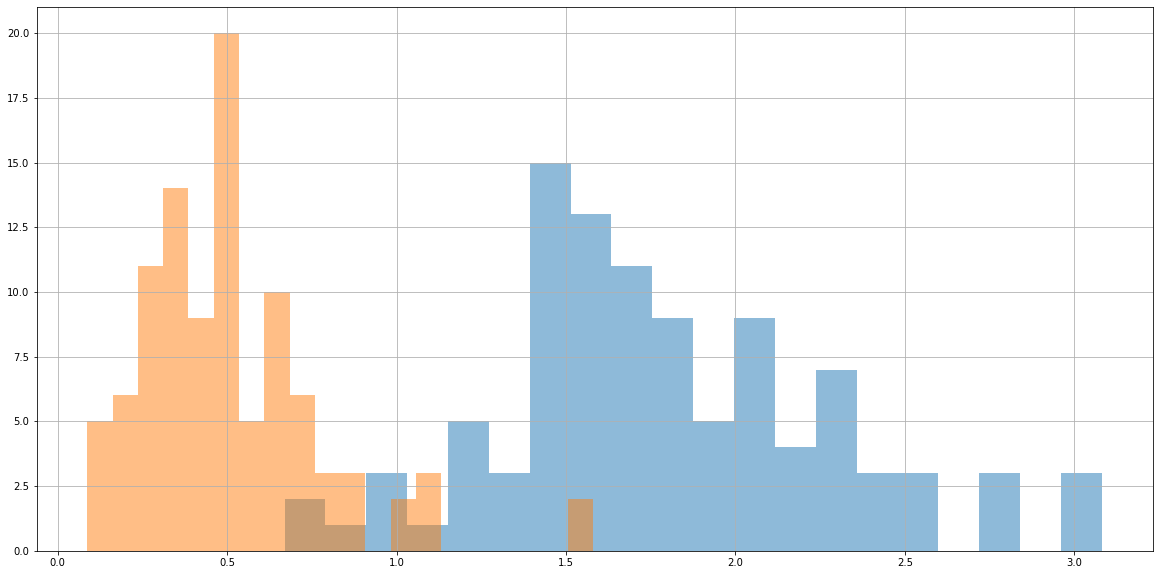

In [44]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
check_outliers(dr.df, uids[:100])['MAD_max'].hist(bins=20, ax=ax, alpha=0.5)
check_outliers(dr.df, dr.idx_uid[:100])['MAD_max'].hist(bins=20, ax=ax, alpha=0.5)

In [40]:
MAD_max = check_outliers(df_ztf, uids)

In [42]:
# uids2 = MAD_max.sort_values(['g','r'], ascending=False).head(20)['uid'].values

In [9]:
def check_outliers_plot(df, uids):
    MAD_max = pd.DataFrame(columns=['uid','g','r','i','z','y'])
    # make sure we have multiindexing
    colors = {'u':'m', 'g':'g', 'r':'r','i':'k','z':'b'}
    fig, axes = plt.subplots(20,1, figsize = (30,70))
    for uid, ax in zip(uids, axes.ravel()):
        group_all = df.loc[uid].sort_values('mjd')
        MAD_maxes = {'uid':uid}
        append = False
        for band in group_all.index.unique():
            group = group_all.loc[band]
            ax.scatter(group['mjd'], group['mag'], label=band, s=0.6, c=colors[band])
            ax.errorbar(group['mjd'], group['mag'], yerr=group['magerr'], lw=0.5, color=colors[band])
            try:
                n = len(group)
                MAD = abs(group['mag'] - group['mag'].rolling(n//2, center=True).median().fillna(method='bfill').fillna(method='ffill'))
                if MAD.max() > 0:
                    MAD_maxes[band] = MAD.max()
                    append = True
                outlier = group[MAD>1]
                ax.scatter(outlier['mjd'], outlier['mag'], marker='*', s=100, c='r')
            except:
                print('pass')
                pass
        
        if append:
            MAD_max = MAD_max.append(MAD_maxes, ignore_index=True)

        ax.legend()
    return MAD_max.astype({'uid':np.uint32})

KeyError: 'y'

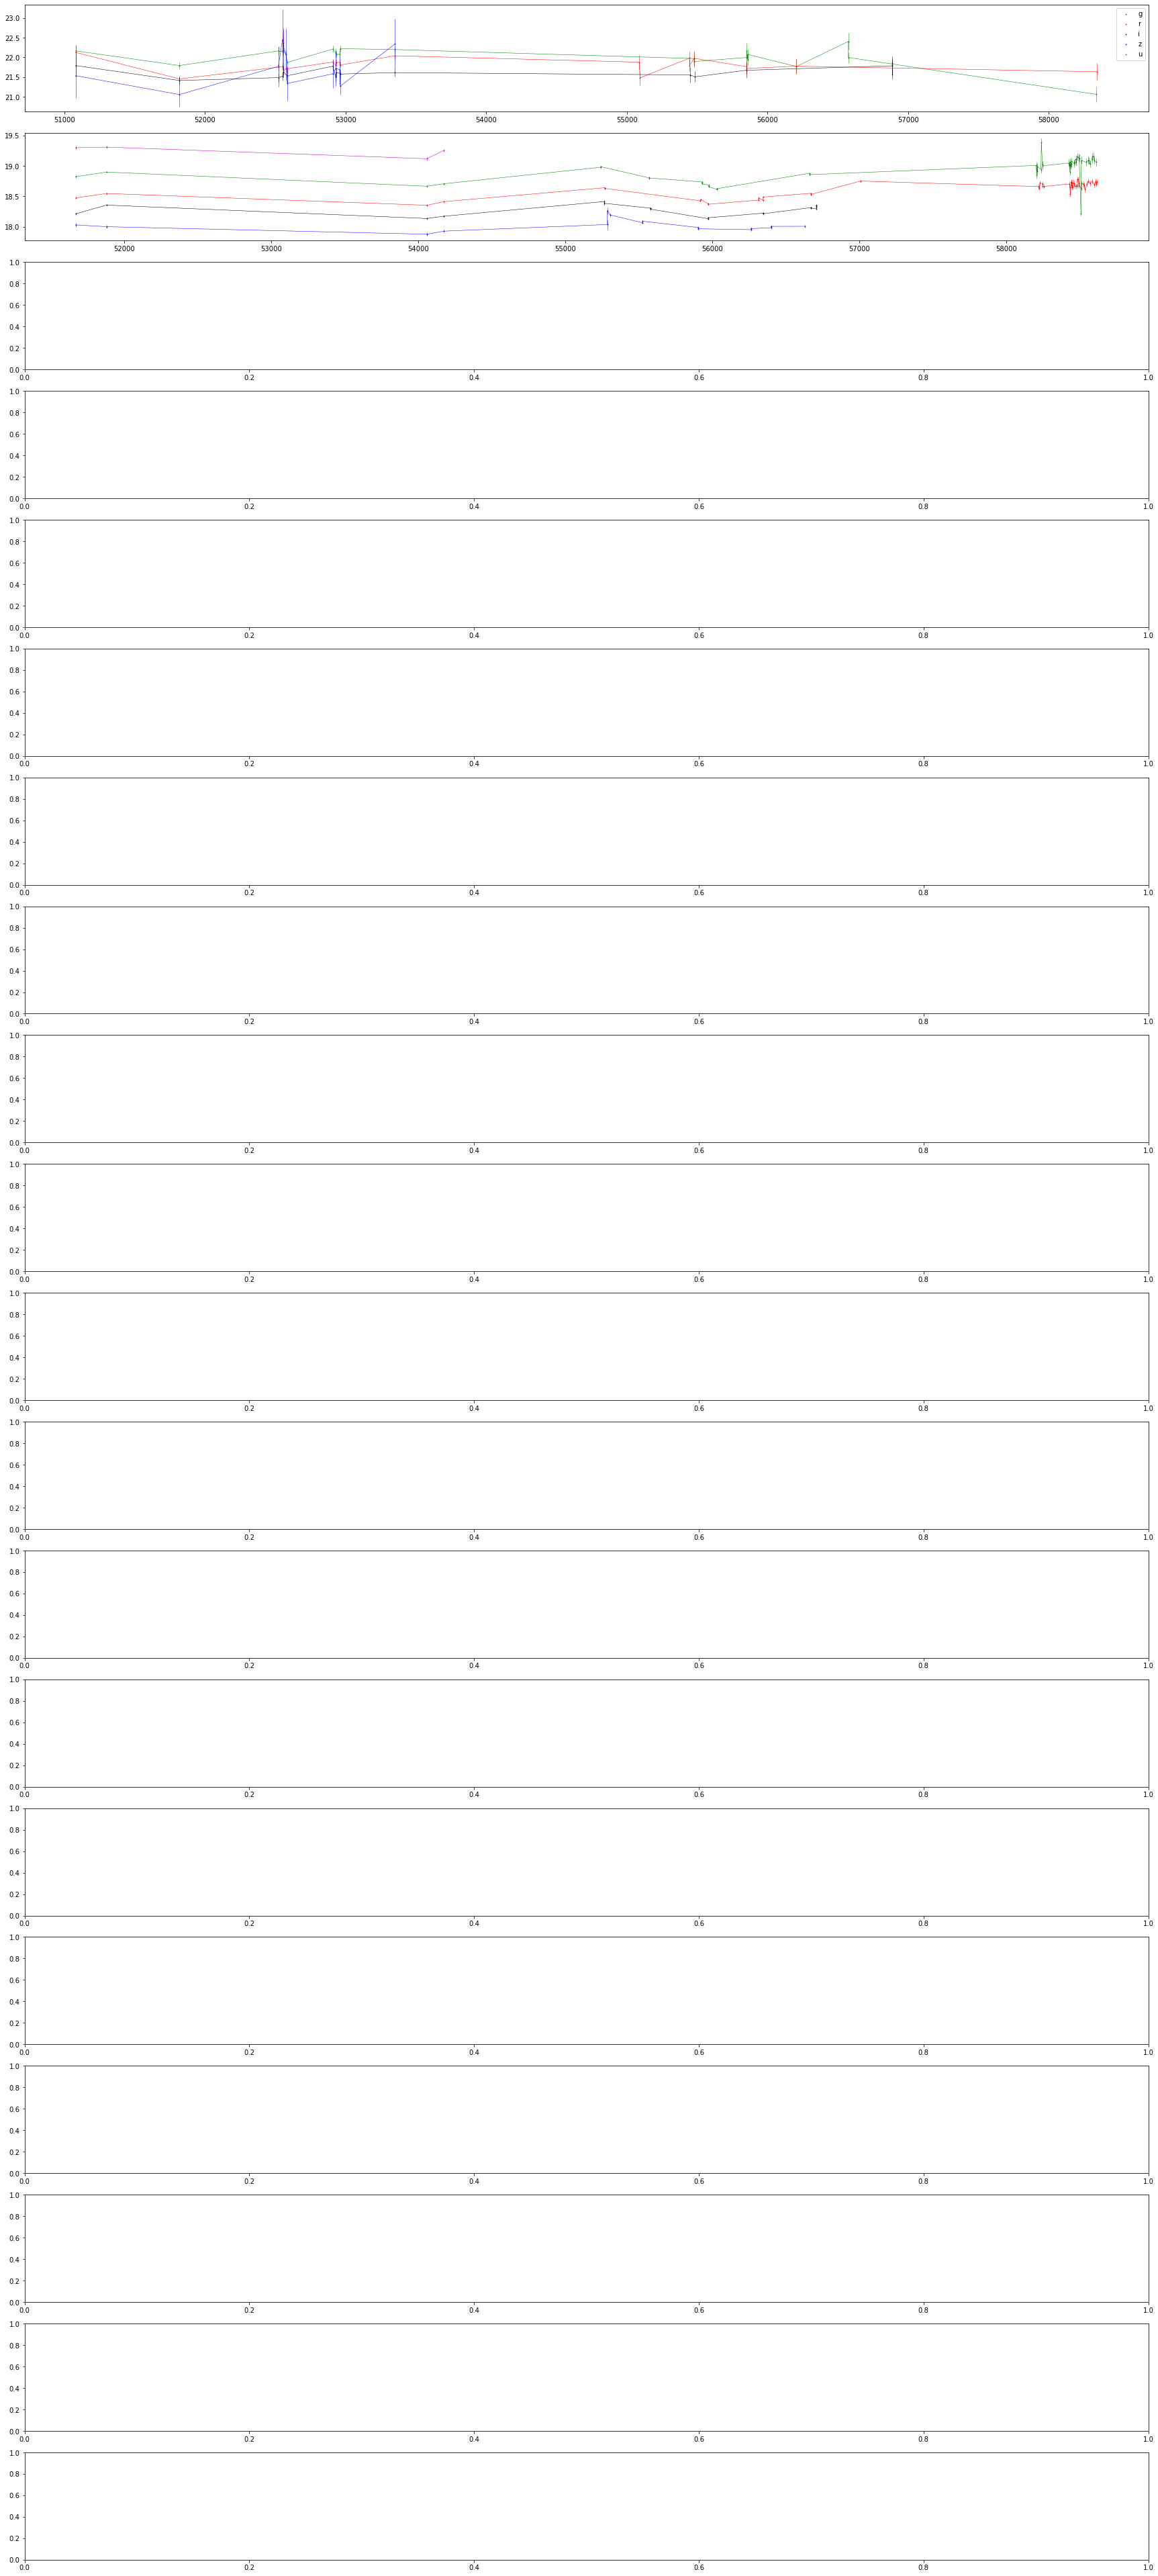

In [10]:
MAD_max = check_outliers_plot(df, uids)

In [1]:
dr.plot_series([346031,346031])

NameError: name 'dr' is not defined